## Import libraries

In [3]:
# Standard libraries
import os
import glob
import shutil

# General libraries
import pathlib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2 as cv
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline

# Tensorflow and Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

Checking Tensorflow version

In [4]:
tf.__version__

'2.10.0'

Checking whether Tensorflow using GPU or not

In [5]:
len(tf.config.list_physical_devices('GPU')) > 0

True

In [6]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
print('Num GPU available:', len(tf.config.experimental.list_physical_devices('GPU')))

Num GPU available: 1


In [8]:
tf.test.is_built_with_cuda()

True

In [9]:
tf.test.is_built_with_gpu_support()

True

In [10]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

Limiting GPU growth memory

In [11]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


## Global constants

In [12]:
# Classes
NUM_CLASSES = 4
CLASS_NAMES = ['Cataract', 'Diabetic Retinopathy', 'Glaucoma', 'Normal']

# Image size
IMG_SIZE_1 = 100
IMG_SIZE_2 = 150
IMG_SIZE_3 = 180
IMG_SIZE_4 = 224
IMG_SIZE_5 = 2551
IMG_SIZE = IMG_SIZE_2

# Batch size
BATCH_SIZE = 32

# Epoch
EPOCHS = 100
FINE_TUNE_EPOCHS = 10

## Data preprocessing

### Loading data

In [13]:
# os.chdir('D:\\Kuliah\\Proyek Akhir 2022\\Dataset (Splitted)')
os.chdir('D:\\Kuliah\\Proyek Akhir 2022\\Dataset')
dataset_dir = os.getcwd()

print('Dataset directory:', dataset_dir)

Dataset directory: D:\Kuliah\Proyek Akhir 2022\Dataset


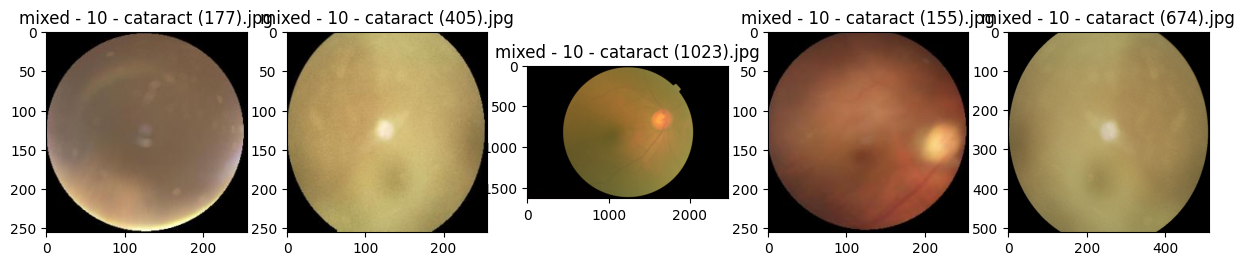

In [14]:
# Show 5 random cataract images

import random
import matplotlib.image as mpimg

plt.figure(figsize=(15,15))

# cataract_folder = train_url + '\\Cataract'
# dr_folder = train_url + '\\Diabetic Retinopathy'
# glaucoma_folder = train_url + '\\Glaucoma'
# normal_folder = train_url + '\\Normal'

cataract_folder = dataset_dir + '\\Cataract'
dr_folder = dataset_dir + '\\Diabetic Retinopathy'
glaucoma_folder = dataset_dir + '\\Glaucoma'
normal_folder = dataset_dir + '\\Normal'

for i in range(5):
    file = random.choice(os.listdir(cataract_folder))
    image_path = os.path.join(cataract_folder, file)
    img = mpimg.imread(image_path)
    ax = plt.subplot(1, 5, i + 1)
    ax.title.set_text(file)
    plt.imshow(img)

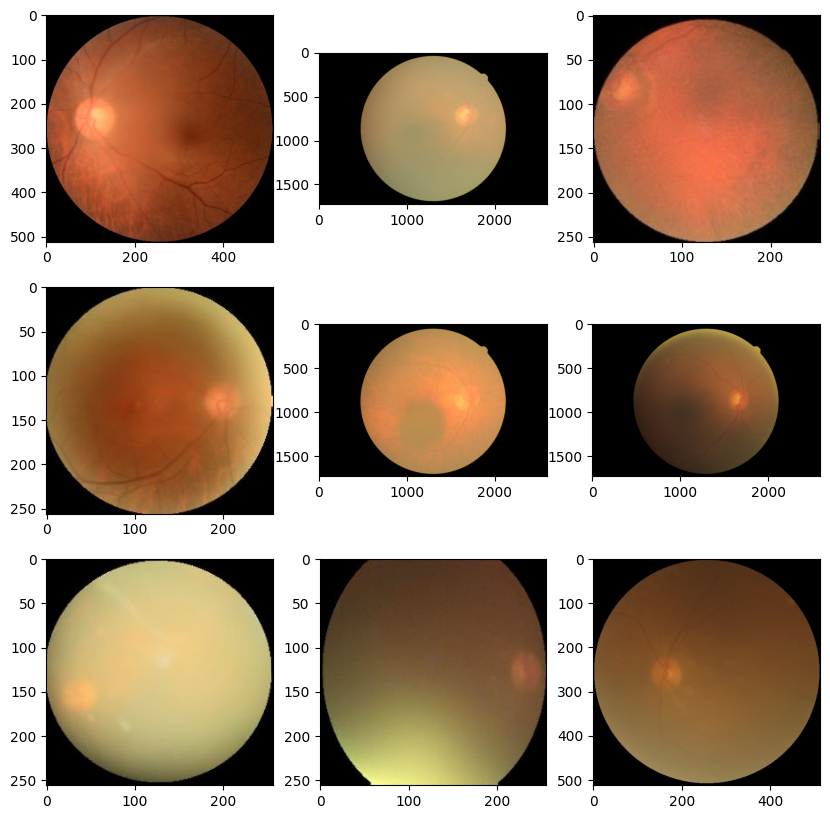

In [15]:
# Create a grid of 3x3 images

import random 
import matplotlib.image as mpimg

fig, ax = plt.subplots(3, 3, figsize=(10,10))

for i in range(3):
    for j in range(3):
        file = random.choice(os.listdir(cataract_folder))
        image_path = os.path.join(cataract_folder, file)
        img = mpimg.imread(image_path)
        ax[i][j].imshow(img, cmap=plt.get_cmap("gray"))

# Show the plot
# plt.show()

Load the training data

In [31]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

train_dataset

Found 4312 files belonging to 4 classes.
Using 3450 files for training.


<BatchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [32]:
print(type(train_dataset))
print(len(train_dataset))

<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
108


Load the validation data

In [33]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset='validation',
    seed=123,
    label_mode=None,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

val_dataset

Found 4312 files belonging to 1 classes.
Using 862 files for validation.


<BatchDataset element_spec=TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None)>

In [34]:
print(type(val_dataset))
print(len(val_dataset))

<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
27


In [20]:
# class_names = train_dataset.class_names
# 
# plt.figure(figsize=(10, 10))
# for images, labels in train_dataset.take(1):
#     for i in range(9):
#         ax = plt.subplot(3, 3, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title(class_names[labels[i]])
#         plt.axis("off")

Load the test data

In [35]:
val_batches = tf.data.experimental.cardinality(val_dataset)

test_dataset = val_dataset.take(val_batches // 5)
val_dataset = val_dataset.skip(val_batches // 5)

In [36]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 22
Number of test batches: 5


In [37]:
print(len(test_dataset))

5


### Configure dataset performance

In [38]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Data augmentation

In [39]:
# from tensorflow.image import flip_left_right, flip_up_down, adjust_brightness, adjust_contrast, adjust_saturation
# 
# def augment(image, label):
#     image = flip_left_right(image)
#     image = flip_up_down(image)
#     image = adjust_brightness(image, delta=0.1)
#     image = adjust_contrast(image, contrast_factor=1.75)
#     image = adjust_saturation(image, saturation_factor=1)
# 
#     return (image, label)
# 
# train_dataset = train_dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
# 
# iterator = iter(train_dataset)

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomFlip('vertical'),
    tf.keras.layers.RandomContrast(0.3),
    tf.keras.layers.RandomBrightness(0.2)
])

In [40]:
# for image, _ in train_dataset.take(1):
#     plt.figure(figsize=(10, 10))
#     first_image = image[0]
#     for i in range(9):
#         ax = plt.subplot(3, 3, i + 1)
#         augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
#         plt.imshow(augmented_image[0] / 255)
#         plt.axis('off')

### Rescale pixel values

In [41]:
resnet50_preprocess_input = tf.keras.applications.resnet50.preprocess_input

## Create the base model of pretrained-model

In [42]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50

INPUT_SHAPE = (IMG_SIZE, IMG_SIZE) + (3,)

resnet50_model = ResNet50(
    input_shape=INPUT_SHAPE,
    include_top=False,
    weights='imagenet'
)

In [43]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = resnet50_model(image_batch)
print('Feature batch shape:', feature_batch.shape)

Feature batch shape: (32, 5, 5, 2048)


## Feature extraction

### Freeze the convolutional base

In [44]:
resnet50_model.trainable = False

In [45]:
resnet50_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1_conv[0][0]']      

### Add classification head

In [46]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print('Feature batch average shape:', feature_batch_average.shape)

Feature batch average shape: (32, 2048)


In [47]:
prediction_layer = tf.keras.layers.Dense(4)
prediction_batch = prediction_layer(feature_batch_average)
print('Prediction batch shape:', prediction_batch.shape)

Prediction batch shape: (32, 4)


Create the model

In [48]:
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

x = data_augmentation(inputs)
x = resnet50_preprocess_input(x)
x = resnet50_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)

outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

In [50]:
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy

metrics = ['accuracy', SparseCategoricalAccuracy(), Precision(), Recall(), AUC()]

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=SparseCategoricalCrossentropy(from_logits=False),
    metrics=metrics
)

In [51]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 150, 150, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 150, 150, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                      

In [52]:
len(model.trainable_variables)

2

### Train the model

In [54]:
# loss0, accuracy0 = model.evaluate(val_dataset)

In [55]:
# print("initial loss: {:.2f}".format(loss0))
# print("initial accuracy: {:.2f}".format(accuracy0))

In [56]:
history = model.fit(
    train_dataset,
    # epochs=EPOCHS,
    epochs=25,
    validation_data=val_dataset
)

Epoch 1/25


ValueError: in user code:

    File "d:\Application\Anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "d:\Application\Anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "d:\Application\Anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "d:\Application\Anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 998, in train_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "d:\Application\Anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 1092, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "d:\Application\Anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\compile_utils.py", line 605, in update_state
        metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "d:\Application\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\metrics_utils.py", line 77, in decorated
        update_op = update_state_fn(*args, **kwargs)
    File "d:\Application\Anaconda3\envs\tf-gpu\lib\site-packages\keras\metrics\base_metric.py", line 143, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "d:\Application\Anaconda3\envs\tf-gpu\lib\site-packages\keras\metrics\metrics.py", line 906, in update_state  **
        return metrics_utils.update_confusion_matrix_variables(
    File "d:\Application\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\metrics_utils.py", line 674, in update_confusion_matrix_variables
        y_pred.shape.assert_is_compatible_with(y_true.shape)

    ValueError: Shapes (None, 4) and (None, 1) are incompatible
